In [1]:
h1 = pyfits.open('pohl_h2/mod-rev-nhl2int.fit')
h2 = pyfits.open('pohl_h2/mod-gp-cor2int.fit')
h3 = pyfits.open('pohl_h2/mod-rev-phl2int.fit')

In [4]:
print h1[0].header.cards
print 
print h2[0].header.cards
print 
print h3[0].header.cards





('SIMPLE', True, 'Written by IDL:  Thu Mar 19 12:37:47 2009')
('BITPIX', 16, '16-bit twos complement binary integer')
('NAXIS', 3, 'Number of axes')
('NAXIS1', 46, '/ Number pixels on axis 1')
('NAXIS2', 2881, 'Number pixels on axis 2')
('NAXIS3', 201, '/ Number pixels on axis 3')
('CTYPE1', 'DISTANCE IN PC', 'axis 1 coord type')
('CRVAL1', 50, '/ coord value at CRPIX1')
('CDELT1', 100, '/ pixel spacing for axis 1')
('CRPIX1', 1, '/ ref pixel for axis 1')
('CTYPE2', 'GLON-CAR', 'axis 2 coord type')
('CRVAL2', -180.0, 'coord value at CRPIX2')
('CDELT2', 0.125, 'pixel spacing for axis 2')
('CRPIX2', 1.0, 'ref pixel for axis 2')
('CTYPE3', 'GLAT-CAR', 'axis 3 coord type')
('CRVAL3', -30.0, '/ coord value at CRPIX3')
('CDELT3', 0.125, 'pixel spacing for axis 3')
('CRPIX3', 1.0, 'ref pixel for axis 3')
('DATAMIN', -1.130486, 'minimum real value')
('DATAMAX', 30.12741, 'maximum real value')
('COMMENT', 'deconvolution of CFA CO data cube by MKP', '')
('COMMENT', 'value is W_CO in K km/s that 

In [108]:
from scipy.interpolate import RegularGridInterpolator

hdu1 = pyfits.open('pohl_h2/mod-rev-nhl2int.fit')
hdu2 = pyfits.open('pohl_h2/mod-gp-cor2int.fit')
hdu3 = pyfits.open('pohl_h2/mod-rev-phl2int.fit')


R_solar = 8.5
nx,ny,nz = 1201,1201,41
x,y,z = np.linspace(-15,15,nx), np.linspace(-15,15,nx), np.linspace(-.5,.5,nz)
mapcube = np.zeros(shape=(nz,ny,nx))

data2 = hdu2[0].data
h2 = hdu2[0].header
b = np.linspace(-5, 5, h2['NAXIS3'])
l = np.linspace(-180., 180., float(h2['NAXIS2']))
d = np.linspace(h2['CRVAL1'], float(h2['CRVAL1']+h2['NAXIS1']*h2['CDELT1']), h2['NAXIS1']+1)[:-1]/1000.
rgi_gp = RegularGridInterpolator((b,l,d), data2,method='linear',bounds_error=False,fill_value=np.float32(0.0))


data1 = hdu1[0].data
h1 = hdu1[0].header
b = np.linspace(-30, -5, h1['NAXIS3'])
l = np.linspace(-180., 180., float(h1['NAXIS2']))
d = np.linspace(h1['CRVAL1'], float(h1['CRVAL1']+h1['NAXIS1']*h1['CDELT1']), h1['NAXIS1']+1)[:-1]/1000.
rgi_south = RegularGridInterpolator((b,l,d), data1,method='linear',bounds_error=False,fill_value=np.float32(0.0))


data3 = hdu3[0].data
h3 = hdu3[0].header
b = np.linspace(5, 30, h3['NAXIS3'])
l = np.linspace(-180., 180., float(h3['NAXIS2']))
d = np.linspace(h3['CRVAL1'], float(h3['CRVAL1']+h3['NAXIS1']*h3['CDELT1']), h3['NAXIS1']+1)[:-1]/1000.
rgi_north = RegularGridInterpolator((b,l,d), data3,method='linear',bounds_error=False,fill_value=np.float32(0.0))


from astropy.coordinates import cartesian_to_spherical as cts
def GetPos(x,y,z):
    r,b,l = cts(-(x-R_solar), -y, z)
    return r, np.rad2deg(b), np.rad2deg(l)

for ix, xx in enumerate(x):
    print '\r Fraction Complete', ix/float(len(x)), 
    for iy, yy in enumerate(y):
        dd,bb,ll = GetPos(xx,yy,z)
        
        idx_n = np.where(bb>5)[0]
        idx_s = np.where(bb<-5)[0]
        idx_gp= np.where( (bb<5) & (bb>-5) )[0]
        
        if idx_n != []:
            mapcube[idx_n,iy,ix] = rgi_north((bb[idx_n],ll,dd[idx_n]))
        if idx_s != []:
            mapcube[idx_s,iy,ix] = rgi_south((bb[idx_s],ll,dd[idx_s]))
        if idx_gp != []:
            mapcube[idx_gp,iy,ix] = rgi_gp((bb[idx_gp],ll,dd[idx_gp]))
        

        
mapcube = np.clip(mapcube, 0, None)/100.
        
        

# for ib, b_pos in enumerate(b):
#     for il, l_pos in enumerate(y):
#         xx = R_solar-d*np.cos(l)*np.cos(b)
#         yy = -d*np.sin(l)*np.cos(b)
#         zz = d*sin(b)
#         ix,iy,iz = np.argmin(np.abs(x-xx)), np.argmin(np.abs(y-yy)), np.argmin(np.abs(z-zz))
#         idx = np.where(ix<)
        
        

 Fraction Complete 0.999167360533


In [46]:
mapcube2 = mapcube.copy()

rgi = RegularGridInterpolator((z,y,x), mapcube,method='linear',bounds_error=False,fill_value=np.float32(0.0))

correct_idx = np.where((z<.5) & (z>-.5))[0]


r_interp = np.linspace(0,20,40)
theta_interp1 = np.linspace(-165,-160,10)
theta_interp2 = np.linspace(160,165,10)

avg1 = []
avg2 = [] 

for r_big in r_interp:
    xx,yy = r_big*np.cos(theta_interp1), r_big*np.sin(theta_interp1)
    ring_avg = np.average([rgi((z,yy[i],xx[i])) for i in range(len(xx))],axis=0)
    avg1.append(ring_avg)
    
    xx,yy = r_big*np.cos(theta_interp2), r_big*np.sin(theta_interp2)
    ring_avg = np.average([rgi((z,yy[i],xx[i])) for i in range(len(xx))],axis=0)
    avg2.append(ring_avg)
    
rgi_r_theta1 = RegularGridInterpolator((r_interp,z), avg1, method='linear',
                                      bounds_error=False,fill_value=np.float32(0.0))
rgi_r_theta2 = RegularGridInterpolator((r_interp,z), avg2, method='linear',
                                      bounds_error=False,fill_value=np.float32(0.0))

for ix, xx in enumerate(x):
    print '\r Correcting Artifacts. Fraction Complete', ix/float(len(x)), 
    for iy, yy in enumerate(y):
        
        r_little = np.sqrt((xx-R_solar/1.8)**2 + yy**2)
        theta_little = np.rad2deg(np.arctan2(yy,xx-R_solar/2.))
        # Check if we lie near the circle.
        if (r_little < R_solar/2.1 + .05*R_solar) and (r_little > R_solar/2.1-.05*R_solar):
            if ((theta_little>25 and theta_little<155) or 
                (theta_little<-25 and theta_little>-155)):
                #mapcube2[:,iy,ix] = 0
                
                # If we are in the artifact region, interpolate from the sides.
                theta_big = np.arctan2(yy,xx)
                r_big = np.sqrt(yy**2+xx**2)
                
                x1,y1 = r_big*np.cos(theta_big-np.deg2rad(15)), r_big*np.sin(theta_big-np.deg2rad(15))
                x2,y2 = r_big*np.cos(theta_big+np.deg2rad(15)), r_big*np.sin(theta_big+np.deg2rad(15))
                mapcube2[correct_idx,iy,ix] = .5*mapcube[correct_idx,iy,ix] + .25*(rgi((z[correct_idx],y1,x1))+rgi((z[correct_idx],y2,x2)))
        
        

 Correcting Artifacts. Fraction Complete 0.998336106489


/home/carlson/ipython/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


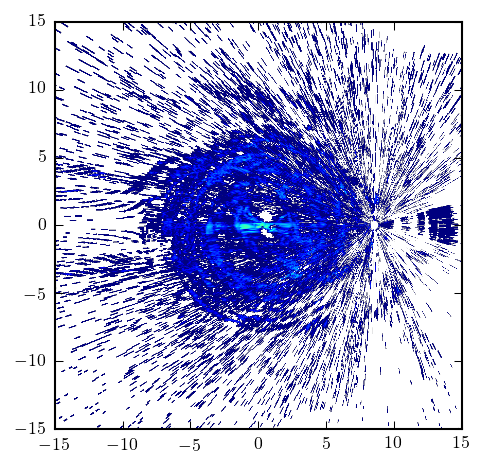

<matplotlib.colorbar.Colorbar instance at 0x7fbca50cac68>

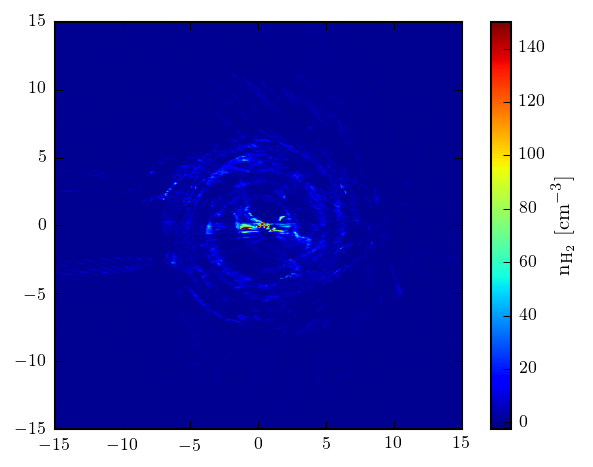

In [112]:
plt.imshow(np.log10(mapcube[20]/(3.086e18*100)*2e20), origin='lower',extent=[-15,15,-15,15],vmin=-2.5,vmax=2.5)
#plt.imshow(np.log10(np.sum(mapcube/(3.086e18*100)*2e20,axis=0)), origin='lower',extent=[-15,15,-15,15],vmin=-2.5)
plt.show()
plt.imshow(np.sum(mapcube2/3.1e18*2e20,axis=0), origin='lower',extent=[-15,15,-15,15],vmin=-2.5, vmax=150)
plt.colorbar(label=r'$\rm n_{H_2}\ [cm^{-3}]$')

In [109]:
hdu = pyfits.PrimaryHDU(mapcube.astype(np.float32)/(3.086e18*100))

hdu.header['CTYPE1'] = 'x in kpc'
hdu.header['CTYPE2'] = 'y in kpc'
hdu.header['CTYPE3'] = 'z in kpc'
hdu.header['CRVAL1'] = np.min(x)
hdu.header['CRVAL2'] = np.min(y)
hdu.header['CRVAL3'] = np.min(z)
hdu.header['CDELT1'] = x[1]-x[0]
hdu.header['CDELT2'] = y[1]-y[0]
hdu.header['CDELT3'] = z[1]-z[0]
hdu.header.add_comment('Generated by Eric Carlson using maps from Martin Pohl, no')
hdu.header.add_comment('correction of artifacts due to forbidden velocities.')
hdu.header.add_comment('Units now in W_CO/cm^3.  Earth is at (8.5,0,0) kpc with -y for positive longitudes. ') 
hdulist = pyfits.HDUList([hdu,])
hdulist.writeto('CO_Pohl_galprop_8500.fits',clobber=True)
hdulist.writeto('/data/galprop2/FITS/CO_Pohl_galprop_8500.fits',clobber=True)
hdulist[0].header.cards


('SIMPLE', True, 'conforms to FITS standard')
('BITPIX', -32, 'array data type')
('NAXIS', 3, 'number of array dimensions')
('NAXIS1', 1201, '')
('NAXIS2', 1201, '')
('NAXIS3', 41, '')
('EXTEND', True, '')
('CTYPE1', 'x in kpc', '')
('CTYPE2', 'y in kpc', '')
('CTYPE3', 'z in kpc', '')
('CRVAL1', -15.0, '')
('CRVAL2', -15.0, '')
('CRVAL3', -0.5, '')
('CDELT1', 0.025000000000000355, '')
('CDELT2', 0.025000000000000355, '')
('CDELT3', 0.025000000000000022, '')
('COMMENT', 'Generated by Eric Carlson using maps from Martin Pohl, no', '')
('COMMENT', 'correction of artifacts due to forbidden velocities.', '')
('COMMENT', 'Units now in W_CO/cm^3.  Earth is at (8.5,0,0) kpc with -y for positive', '')
('COMMENT', 'longitudes.', '')

In [ ]:
plt.imshow(np.sum(hdu3[0].data, axis=2), origin='lower', vmin=0,vmax=15000)
#plt.colorbar()
plt.show()
plt.imshow(np.sum(hdu2[0].data*3.08567758e18,axis=2), origin='lower', vmin=0,)
plt.colorbar()
plt.show()
plt.imshow(np.sum(hdu1[0].data, axis=2), origin='lower', vmin=0,vmax=15000)
#plt.colorbar()
plt.show()

/home/carlson/ipython/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/home/carlson/anaconda/lib/python2.7/site-packages/healpy/pixelfunc.py:252: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/carlson/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:2195: RuntimeWarning: invalid value encountered in less_equal
  condition = umath.less_equal(mabs(xnew - value), atol + rtol * mabs(value))
/home/carlson/anaconda/lib/python2.7/site-packages/healpy/projaxes.py:993: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/home/carlson/anaconda/lib/python2.7/site-packages/healpy/projaxes.py:994: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


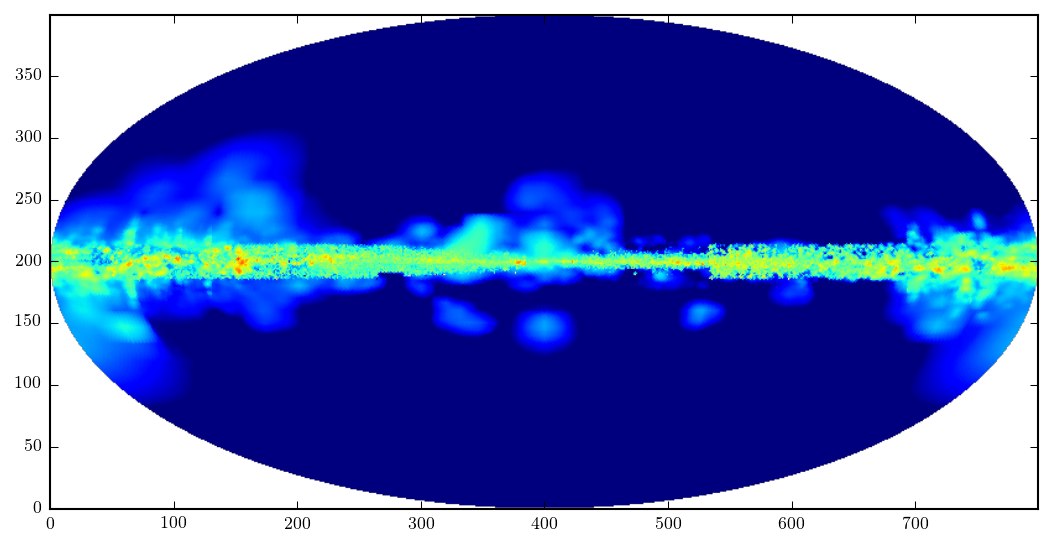

In [74]:
import healpy
def ReadFits(fname, length):
        d = pyfits.open(fname)[1].data
        return np.array([d.field(i) for i in range(length)])

a = healpy.mollview(np.log10(1e20*ReadFits('/data/galprop2/output/pi0_decay_healpix_54_Pohl_H2_8500_test.gz',38)[30]), return_projected_map=True)
plt.clf()
plt.imshow(a,vmin=16,vmax=21, origin='lower')
#healpy.mollview(np.log10(ReadFits('/data/galprop2/output/healpix_54_NS_HI_8500_test.gz',38)[30]))

/home/carlson/ipython/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


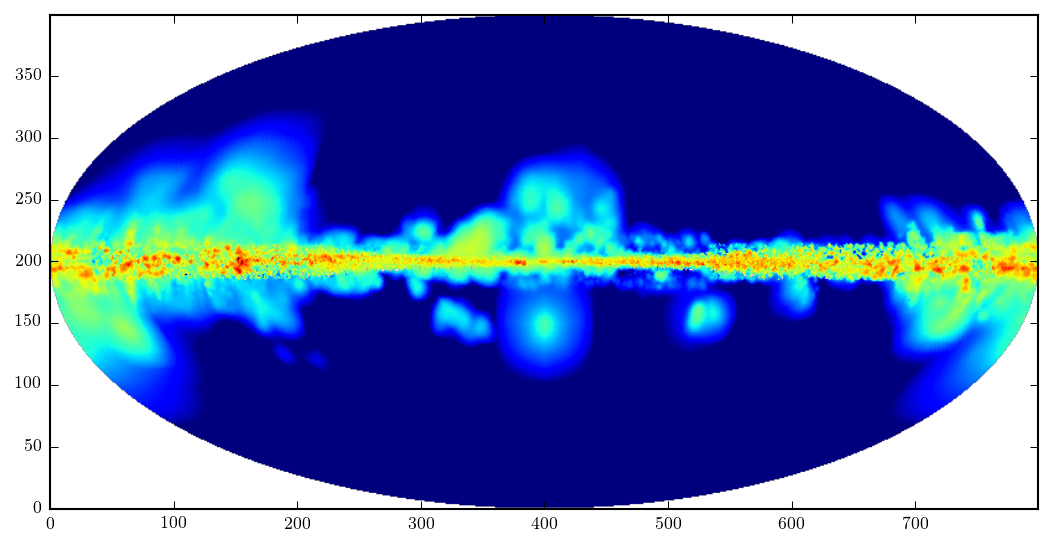

In [110]:
import healpy
def ReadFits(fname, length):
        d = pyfits.open(fname)[1].data
        return np.array([d.field(i) for i in range(length)])

a = healpy.mollview(np.log10(1e20*ReadFits('/data/galprop2/output/pi0_decay_healpix_54_Pohl_H2_8500_test.gz',38)[30]), return_projected_map=True)
plt.clf()
plt.imshow(a,vmin=16,vmax=21, origin='lower')
#healpy.mollview(np.log10(ReadFits('/data/galprop2/output/healpix_54_NS_HI_8500_test.gz',38)[30]))

/home/carlson/ipython/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


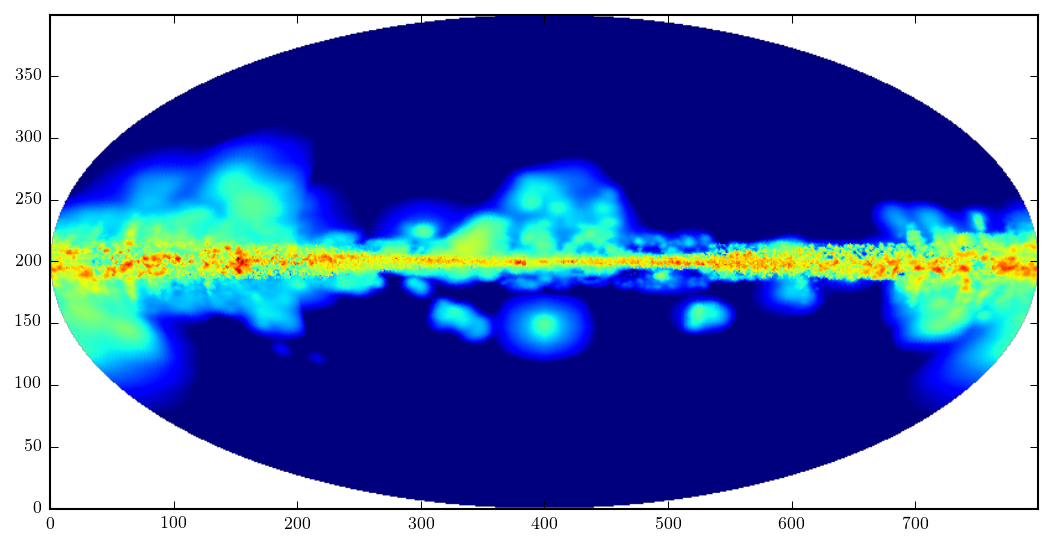

In [107]:
import healpy
def ReadFits(fname, length):
        d = pyfits.open(fname)[1].data
        return np.array([d.field(i) for i in range(length)])

a = healpy.mollview(np.log10(1e20*ReadFits('/data/galprop2/output/pi0_decay_healpix_54_Pohl_H2_8500_test.gz',38)[30]), return_projected_map=True)
plt.clf()
plt.imshow(a,vmin=16,vmax=21, origin='lower')
